# Two-Body Problem

The two body problem is a simplest example of the N-Body Problem (with n=2). The following examples are provided to illustrate the Two Body Problem:
* Orbit of the Moon around the Earth (Earth-centric orbit)
* Orbit of a Binary Star System (which has a Bary-centric mass point)

## Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mayavi import mlab
from PIL import Image
import glob
import os
import shutil

## Necessary Functions

Functions necessary to solve the ODE System in State-Space

In [2]:
def derivatives(state):
    """
    Function that calculates the derivate of the state at a given time slice.
    Solves for the acceleration and velocity of the objects that are evaluated for the trajectories (they are the derivatives of the velocity and position with respect to time.)

    ____
    Inputs:
        state (ndarray): State of the system at a given time slice
    ____
    Outputs:
        (ndarray): Containers the value of the derivatives of the states by solving the derivative equation   
    """
    # Unpack the state vector
    r1 = state[0:3]
    v1 = state[3:6]
    r2 = state[6:9]
    v2 = state[9:12]

    # Compute the distance vector and its magnitude
    r = r2 - r1
    distance = np.linalg.norm(r)

    # Compute the gravitational force
    force = G * m1 * m2 / distance**2

    # Compute the accelerations
    a1 = force / m1 * r / distance
    a2 = -force / m2 * r / distance

    # Return the derivatives of the state vector
    return np.concatenate((v1, a1, v2, a2))


In [3]:
# Function that solves the state-space equation at the given time-step using the 4th Order Runge-Kutta Method
def rk4_step(f, y, t, dt):
    """
    Equation to solve: y' = f(y(t)) (where y' is the first derivative of y with respect to t)
    y[n+1] = y[n] + h*(k1 + 2*k2 + 2*k3 + k4)/4
    where:
        k1 = f(y[n])
        k2 = f(y[n] + 0.5*dt*k1)
        k3 = f(y[n] + 0.5*dt*k2)
        k4 = f(y[n] + dt*k3)

    ____
    Inputs:
        f (function): Input Function for the derivatives of the state-space equation system
        y (ndarray): States of the ODE system at a certain time step
        t (float): Time value
        dt (float): Time step
    
    ____
    Outputs:
        (ndarray): State of the ODE System at the next time step
    """
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Function that solves the ODE Equation system in state-space
def solve_ode(f, y0, t_span, dt):
    """
    Function that solves the system of ODEs in state-space method using the 4th Order Runge-Kutta method for time stepping

    ____
    Inputs:
        f (function): Input Function for the derivatives of the state-space equation system
        y0 (ndarray): Initial state of the state-space system (Initial Condition of the ODE System)
        t_span (tuple): Tuple containing the Start and End Time for the ODE Solver
        dt (float): Time step for the ODE Solver
    
    ____
    Outputs:
        t_values (ndarray): Time slices for the trajectory of the objects
        y_values (ndarray): Trajectory of the objects at each time slice.
    """
    t0, t_end = t_span
    t_values = np.arange(t0, t_end, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4_step(f, y_values[i-1], t_values[i-1], dt)

    return t_values, y_values


## Orbit of the Moon around the Earth

In [5]:
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1

# Masses of the two bodies (in kilograms)
m1 = 5.972e24  # Mass of the Earth
m2 = 7.348e22  # Mass of the Moon

# Initial positions (in meters)
r1_0 = np.array([0, 0, 0])  # Earth at origin
r2_0 = np.array([384400e3, 0, 0])  # Moon, which 384,400 km away from Earth in the X-direction

# Initial velocities (in meters per second)
v1_0 = np.array([0, 0, 0]) # Assumption, the Earth is fixed at Origin
v2_0 = np.array([0, 1022, 0])  # Moon's orbital velocity

# Initial state vector: [r1_x, r1_y, v1_x, v1_y, r2_x, r2_y, v2_x, v2_y]
initial_state = np.concatenate((r1_0, v1_0, r2_0, v2_0))


In [6]:
# Time span (in seconds) --> Defining one month
t_span = (0, 3600*24*30)

# Time step (in seconds) --> One hour
dt = 3600

# Solve the differential equations
t_values, y_values = solve_ode(derivatives, initial_state, t_span, dt)


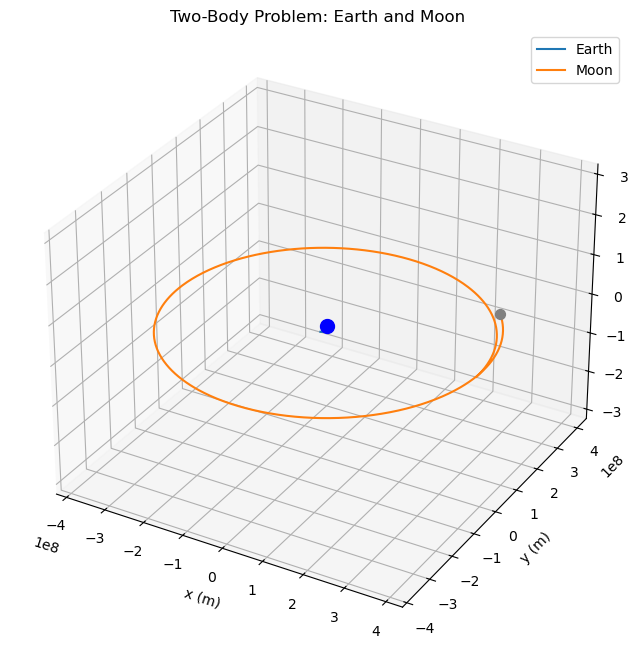

In [7]:
# Visualization with Matplotlib

# Unpack the trajectory of the Earth and the Moon
r1_sol = y_values[:, 0:3]
r2_sol = y_values[:, 6:9]

# Create an instance of the plot with 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory of the Earth and the Moon
ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:,2], label='Earth')
ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:,2], label='Moon')
# Add the final position of the Earth and the Moon
ax.scatter([r1_sol[-1,0]], [r1_sol[-1,1]], [r1_sol[-1,2]], color='blue', s=100)
ax.scatter([r2_sol[-1,0]], [r2_sol[-1,1]], [r2_sol[-1,2]], color='gray', s=50)

ax.legend()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Two-Body Problem: Earth and Moon')
ax.grid()
ax.axis('equal')
plt.show()


In [9]:
# Unpack the velocity of the Earth and the Moon
v1_sol = y_values[:,3:6]
v2_sol = y_values[:,9:12]

# Create directory to store frames
frames_dir = "frames"
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Create a new figure
fig = mlab.figure(size=(800,800), bgcolor=(0,0,0))

# Initialize the Earth and the Moon as points in 3D space with some scale factors (their radii) to fit the canvas
earth = mlab.points3d(r1_sol[0,0], r1_sol[0,1], r1_sol[0,2], scale_factor=3.371e6, color=(0,0,1), resolution=50, name="Earth")
moon = mlab.points3d(r2_sol[0,0], r2_sol[0,1], r2_sol[0,2], scale_factor=1.737e6, color=(1,1,1), resolution=50, name="Moon")

# Initialize the trajectories of the Earth and the Moon with their first positions
earth_traj = mlab.plot3d(r1_sol[:1,0], r1_sol[:1,1], r1_sol[:1,2], color=(0,0,1), tube_radius=None, line_width=1, representation="wireframe", name="Earth Trajectory")
moon_traj = mlab.plot3d(r2_sol[:1,0], r2_sol[:1,1], r2_sol[:1,2], color=(1,1,1), tube_radius=None, line_width=1, representation="wireframe", name="Moon Trajectory")

# Initialize the labels for the Earth and the Moon
earth_label = mlab.text3d(r1_sol[0,0], r1_sol[0,1], r1_sol[0,1], "Earth", scale=1e7, color=(0,0,1))
moon_label = mlab.text3d(r2_sol[0,0], r2_sol[0,1], r2_sol[0,1], "Moon", scale=1e7, color=(1,1,1))

#mlab.axes(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)', ranges=[-4e8, 4e8, -4e8, 4e8, -4e8, 4e8], color)
#mlab.orientation_axes()
mlab.view(azimuth=90, elevation=30, distance=1e9, focalpoint=(0, 0, 0))

# Update Function for the 3D render animation
min_delay = 100
@mlab.animate(delay=min_delay)
def anim():
    for i in range(1, len(t_values)):
        # Update position of objects
        earth.mlab_source.set(x=r1_sol[i,0], y=r1_sol[i,1], z=r1_sol[i,2])
        moon.mlab_source.set(x=r2_sol[i,0], y=r2_sol[i,1], z=r2_sol[i,2])
        earth_traj.mlab_source.reset(x=r1_sol[:i+1,0], y=r1_sol[:i+1,1], z=r1_sol[:i+1,2])
        moon_traj.mlab_source.reset(x=r2_sol[:i+1,0], y=r2_sol[:i+1,1], z=r2_sol[:i+1,2])
        # Update the position of the Labels
        earth_label.position = [r1_sol[i, 0], r1_sol[i, 1], r1_sol[i, 2]]
        moon_label.position = [r2_sol[i, 0], r2_sol[i, 1], r2_sol[i, 2]]
        # Fix View Point
        midpoint = (r1_sol[i] + r2_sol[i]) / 2
        max_distance = np.max(np.linalg.norm(r2_sol[:i+1] - r1_sol[:i+1], axis=1))
        mlab.view(azimuth=45, elevation=45, distance=3.5 * max_distance, focalpoint=midpoint)
        # Update Animation UI
        mlab.process_ui_events()
        # Save the figure
        mlab.savefig(os.path.join(frames_dir, f"frame_{i:04d}.png"))
    yield

anim()
mlab.show()

In [10]:
def make_gif(frame_folder, durations):
    """
    Function that creates an animated GIF from the generated frames of the simulation output and saves it as a GIF file.
    ____
    Inputs:
        frame_folder (string): Path to the directory containing all frames of the simulation render
        durations (list): A list containing the delay durations between the frames.
    ____
    Output:
        None
    """
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save("Moon_Orbit.gif", format="GIF", append_images=frames[1:], save_all=True, duration=durations)

durations = []
for i in range(1, len(t_values)):
    v1_mag = np.linalg.norm(v1_sol[i,:])
    v2_mag = np.linalg.norm(v2_sol[i,:])
    delay = max(1, int(1000/(1 + 0.01*(v1_mag + v2_mag))))
    durations.append(delay/10)

make_gif(frames_dir, durations)
shutil.rmtree(frames_dir)

## Binary Star System

In [14]:
G = 6.67430e-11
m1 = 9.1e31
m2 = 9.1e31
dist = 2*1.4961e11

r1_0 = np.array([-dist/2, 0, 0])
r2_0 = np.array([dist/2, 0, 0])

v1_0 = np.array([0, -30000, 0])
v2_0 = np.array([0, 30000, 0])

initial_state = np.concatenate((r1_0, v1_0, r2_0, v2_0))

t_span = (0, 3600*24*365)
dt = 1800
t_values, y_values = solve_ode(derivatives, initial_state, t_span, dt)

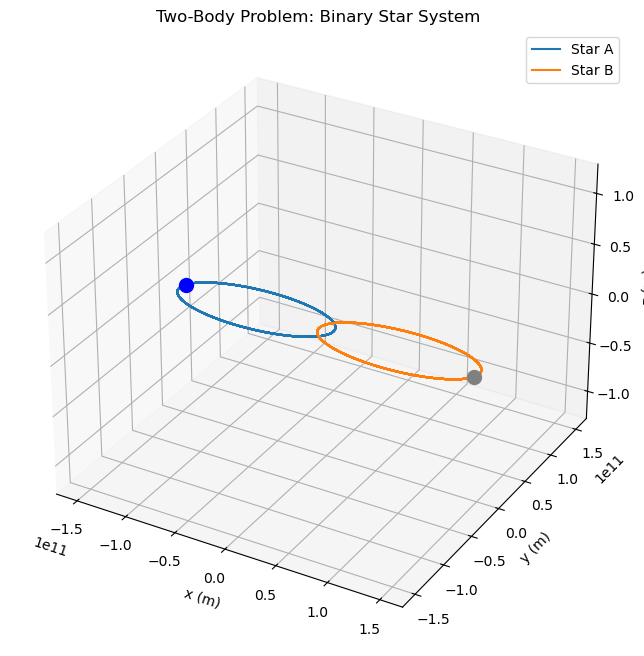

In [15]:
# Visualization with Matplotlib

# Unpack the trajectory of the Earth and the Moon
r1_sol = y_values[:, 0:3]
r2_sol = y_values[:, 6:9]

# Create an instance of the plot with 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory of the Earth and the Moon
ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:,2], label='Star A')
ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:,2], label='Star B')
# Add the final position of the Earth and the Moon
ax.scatter([r1_sol[-1,0]], [r1_sol[-1,1]], [r1_sol[-1,2]], color='blue', s=100)
ax.scatter([r2_sol[-1,0]], [r2_sol[-1,1]], [r2_sol[-1,2]], color='gray', s=100)

ax.legend()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Two-Body Problem: Binary Star System')
ax.grid()
ax.axis('equal')
plt.show()


In [19]:
# Unpack the velocity of the Earth and the Moon
v1_sol = y_values[:,3:6]
v2_sol = y_values[:,9:12]

# Create directory to store frames
# frames_dir = "frames"
# if not os.path.exists(frames_dir):
#     os.makedirs(frames_dir)

# Create a new figure
fig = mlab.figure(size=(800,800), bgcolor=(0,0,0))

# Initialize the Earth and the Moon as points in 3D space with some scale factors (their radii) to fit the canvas
starA = mlab.points3d(r1_sol[0,0], r1_sol[0,1], r1_sol[0,2], scale_factor=6.957e9, color=(1,1,0), resolution=50, name="A")
starB = mlab.points3d(r2_sol[0,0], r2_sol[0,1], r2_sol[0,2], scale_factor=6.957e9, color=(1,1,0), resolution=50, name="A")

# Initialize the trajectories of the Earth and the Moon with their first positions
starA_traj = mlab.plot3d(r1_sol[:1,0], r1_sol[:1,1], r1_sol[:1,2], color=(1,1,0), tube_radius=None, line_width=1, representation="wireframe", name="A Trajectory")
starB_traj = mlab.plot3d(r2_sol[:1,0], r2_sol[:1,1], r2_sol[:1,2], color=(1,1,0), tube_radius=None, line_width=1, representation="wireframe", name="B Trajectory")

# Initialize the labels for the Earth and the Moon
starA_label = mlab.text3d(r1_sol[0,0], r1_sol[0,1], r1_sol[0,1], "A", scale=1e7, color=(1,1,0))
starB_label = mlab.text3d(r2_sol[0,0], r2_sol[0,1], r2_sol[0,1], "B", scale=1e7, color=(1,1,0))

#mlab.axes(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)', ranges=[-4e8, 4e8, -4e8, 4e8, -4e8, 4e8], color)
#mlab.orientation_axes()
mlab.view(azimuth=0, elevation=0, distance=1e12, focalpoint=(0, 0, 0))

# Update Function for the 3D render animation
min_delay = 10
@mlab.animate(delay=min_delay)
def anim():
    for i in range(1, int(0.1*len(t_values))):
        # Update position of objects
        starA.mlab_source.set(x=r1_sol[i,0], y=r1_sol[i,1], z=r1_sol[i,2])
        starB.mlab_source.set(x=r2_sol[i,0], y=r2_sol[i,1], z=r2_sol[i,2])
        starA_traj.mlab_source.reset(x=r1_sol[:i+1,0], y=r1_sol[:i+1,1], z=r1_sol[:i+1,2])
        starB_traj.mlab_source.reset(x=r2_sol[:i+1,0], y=r2_sol[:i+1,1], z=r2_sol[:i+1,2])
        # Update the position of the Labels
        starA_label.position = [r1_sol[i, 0], r1_sol[i, 1], r1_sol[i, 2]]
        starB_label.position = [r2_sol[i, 0], r2_sol[i, 1], r2_sol[i, 2]]
        # Fix View Point
        midpoint = (r1_sol[i] + r2_sol[i]) / 2
        max_distance = np.max(np.linalg.norm(r2_sol[:i+1] - r1_sol[:i+1], axis=1))
        mlab.view(azimuth=0, elevation=0, distance=3.5 * max_distance, focalpoint=midpoint)
        # Update Animation UI
        mlab.process_ui_events()
        # Save the figure
        #mlab.savefig(os.path.join(frames_dir, f"frame_{i:04d}.png"))
    yield

anim()
mlab.show()